# WSI Pipeline v0.3

ITK for affine and non-affine

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import os
from pathlib import Path

import itk
from itkwidgets import compare, checkerboard, view

import cv2
import matplotlib.pyplot as plt
import numpy as np
import openslide
import PIL
import probreg as pr
import qt_wsi_reg.registration_tree as registration
import registration_utilities as ru
import registration_callbacks as rc
import SimpleITK as sitk
from tifffile import imread
import torchstain
from torchvision import transforms

import zarr

from dataorg.frozenstorage import FROZEN_STORAGE_DATA_ORDER, padd_image, shrink_image
import gui

A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.3


Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [3]:
# Functions

# Util functions
####### Utility function #######
def command_iteration(method):
    if (method.GetOptimizerIteration() == 0):
        print("Estimated Scales: ", method.GetOptimizerScales())
    print(f"{method.GetOptimizerIteration():3} = {method.GetMetricValue():7.5f} : {method.GetOptimizerPosition()}")

def plot_sitk_image(image):
    plt.imshow(sitk.GetArrayFromImage(image))

def pil_to_sitk(image):
    # First convert to grayscale
    grayscaled_image = PIL.ImageOps.grayscale(image)
    # To numpy array
    np_image = np.array(grayscaled_image)
    # Rescale numeric values
    np_image = np_image/255.*65025.
    # Reset type
    np_image = np_image.astype(float)
    # Convert to sitk
    sitk_image = sitk.GetImageFromArray(np_image)
    # Convert pixeltype to float32
    sitk_image = sitk.Cast(sitk_image, sitk.sitkFloat32)
    return sitk_image

def sitk_to_pil(image):
    # Convert to numpy array
    np_image = sitk.GetArrayFromImage(image)
    # Rescale
    np_image = np_image/65025.*255.
    # Convert to integer for PIL
    np_image = np_image.astype(np.uint8)
    return PIL.Image.fromarray(np_image)

def extract_image_from_slide(slide):
    return slide.read_region((0,0), 0 , slide.dimensions)  

# Normalization
def normalize(source_path, target_path):
    size = 1024
    src_img = cv2.resize(cv2.cvtColor(cv2.imread(source_path), cv2.COLOR_BGR2RGB), (size, size))
    target_img = cv2.resize(cv2.cvtColor(cv2.imread(target_path), cv2.COLOR_BGR2RGB), (size, size))
    cv2.imwrite('fixed1.tif', src_img)
    #target = cv2.resize(cv2.cvtColor(cv2.imread(source_path), cv2.COLOR_BGR2RGB), (size, size))
    #to_transform = cv2.resize(cv2.cvtColor(cv2.imread(target_path), cv2.COLOR_BGR2RGB), (size, size))
    normalizer = torchstain.normalizers.MacenkoNormalizer(backend='numpy')
    normalizer.fit(src_img)

    T = transforms.Compose([
        transforms.ToTensor(),
        transforms.Lambda(lambda x: x*255)
    ])

    t_to_transform = T(target_img)

    # t_ = time.time()
    norm, H, E = normalizer.normalize(I=target_img, stains=True)
    cv2.imwrite('moving1.tif', norm)

# Functions for processing validation data

FROZEN_STORAGE_DATA_ORDER = {
    'MS-F-1': 0,
    'MS-V-1': 1,
    'MS-FV-1': 2,
    'MS-F-2': 3,
    'MS-V-2': 4,
    'MS-FV-2': 5,
    'MS-F-3': 6,
    'MS-V-3': 7,
    'MS-FV-3': 8,
    'MM-F-1': 9,
    'MM-V-1': 10,
    'MM-FV-1': 11,
    'MM-F-2': 12,
    'MM-V-2': 13,
    'MM-FV-2': 14,
    'MM-F-3': 15,
    'MM-V-3': 16,
    'MM-FV-3': 17,
}

def is_integerable(character):
    try:
        int(character)
        return True
    except ValueError:
        return False

def split_by_core_id_and_sort(file_list, key_list=None):
    if key_list is None:
        key_list=['A', 'B', 'C', 'D']
    dct = {}
    for file_ in file_list:
        # The filenames are currently of the form MM-FV-1_Overview_1_B.tif
        # The ids are in the last part of the filename: ....1_B.tif. The digit points towards the original position 
        # on the slide. The letter groups the cores together based on how they should have been ordered.
        id_ = file_.rsplit('_', maxsplit=1)[-1].split('.', maxsplit=1)[0]
        if id_ not in key_list:
            print(f'Unexpected id {id_} found. Ignoring...')
            continue
        if id_ not in dct:
            dct[id_] = []
        dct[id_].append(file_)
    for key in dct:
        dct[key] = sort_list(dct[key])
    return dct

def get_prefix(scan_name):
    return scan_name.split('_', maxsplit=1)[0]

def sort_list(lst):
    return sorted(lst, key=lambda key: FROZEN_STORAGE_DATA_ORDER[get_prefix(key)])

def split_training_pairs(dct):
    pairs = []
    for key in dct:
        core_slides = dct[key]
        for idx in range(len(core_slides)-1):
            pairs.append((core_slides[idx], core_slides[idx+1]))
    return pairs

def preprocess_image(image):
    # convert to torch Variable
    image = np.expand_dims(image.transpose((2,0,1)),0)
    image = torch.Tensor(image.astype(np.float32)/255.0)
    image_var = Variable(image,requires_grad=False)

    # Resize image using bilinear sampling with identity affine tnf
    image_var = resizeCNN(image_var)
    
    # Normalize image
    image_var = normalize_image(image_var)
    
    return image_var

def load_image_pair(source_image_path, target_image_path, use_cuda=False):
    batch = {'source_image_path': source_image_path, 'target_image_path': target_image_path}
    return batch

def ordered_images_to_batches(image_list):
    batches = []
    for i in range(len(image_list) - 1):
        batch = load_image_pair(image_list[i], image_list[i+1])
        batches.append(batch)
    return batches

In [4]:
PADDED_WIDTH = PADDED_HEIGHT = 725
SHRINK_WIDTH = SHRINK_HEIGHT = 405

In [5]:
TEMP_DIR = 'temp'

if not os.path.exists(TEMP_DIR):
    os.mkdir(TEMP_DIR)

In [6]:
FROZEN_STORAGE_DATA_ORDER

{'MS-F-1': 0,
 'MS-V-1': 1,
 'MS-FV-1': 2,
 'MS-F-2': 3,
 'MS-V-2': 4,
 'MS-FV-2': 5,
 'MS-F-3': 6,
 'MS-V-3': 7,
 'MS-FV-3': 8,
 'MM-F-1': 9,
 'MM-V-1': 10,
 'MM-FV-1': 11,
 'MM-F-2': 12,
 'MM-V-2': 13,
 'MM-FV-2': 14,
 'MM-F-3': 15,
 'MM-V-3': 16,
 'MM-FV-3': 17}

In [7]:
# fixed_img_path = 'exports/frozen_storage/preprocessed_frozen_stoage/MM-F-1_Overview_1_B.tif'
# moving_img_path = 'exports/frozen_storage/preprocessed_frozen_stoage/MM-F-2_Overview_1_B.tif'
# temp_img_path = 'temp/temp.tif'

In [8]:
# fixed_img_path = '/home/maximilw/workbench/wsi/exports/annotations_for_evaluations/MM-F-1.vsi - 20x_1/MM-F-1.vsi - 20x_1.tif'
# moving_img_path = '/home/maximilw/workbench/wsi/exports/annotations_for_evaluations/MM-F-2.vsi - 20x_1/MM-F-2.vsi - 20x_1.tif'
# temp_img_path = 'temp/temp.tif'

In [9]:
# align_affine_images(batches[1]['source_image_path'], batches[1]['target_image_path'])

### Step 0: Normalization

Load, normalize and put back into a temp file.

## Step 1: Simple ITK

### Registration: Rigid

In [10]:
def align_affine_image(fixed_img_path, moving_img_path):
    fixed_img = sitk.ReadImage(fixed_img_path, sitk.sitkFloat32)
    moving_img = sitk.ReadImage(moving_img_path, sitk.sitkFloat32)
    # moving_img = sitk.ReadImage(fixed_img_path, sitk.sitkFloat32)

    initial_transform = sitk.CenteredTransformInitializer(fixed_img, 
                                                          moving_img, 
                                                          sitk.Euler2DTransform(), 
                                                          sitk.CenteredTransformInitializerFilter.GEOMETRY)

    registration_method = sitk.ImageRegistrationMethod()

    # Don't optimize in-place, we would possibly like to run this cell multiple times.
    registration_method.SetInitialTransform(initial_transform, inPlace=False)

    # Similarity metric settings.
    registration_method.SetMetricAsMattesMutualInformation(numberOfHistogramBins=50)
    # registration_method.SetMetricAsMeanSquares()
    registration_method.SetMetricSamplingStrategy(registration_method.RANDOM)
    registration_method.SetMetricSamplingPercentage(0.8)
    registration_method.SetInterpolator(sitk.sitkLinear)

    # Optimizer settings.
    registration_method.SetOptimizerAsExhaustive(numberOfSteps=[0, 25, 25])
    # registration_method.SetOptimizerAsGradientDescent(learningRate=1.0, numberOfIterations=1000, convergenceMinimumValue=1e-6, convergenceWindowSize=10)
    registration_method.SetOptimizerScalesFromPhysicalShift()

    # Setup for the multi-resolution framework.            
    registration_method.SetShrinkFactorsPerLevel(shrinkFactors = [4, 2, 1])
    registration_method.SetSmoothingSigmasPerLevel(smoothingSigmas=[2, 1, 0])

    final_transform = registration_method.Execute(fixed_img, moving_img)

    # Always check the reason optimization terminated.
    print('Final metric value: {0}'.format(registration_method.GetMetricValue()))
    print('Optimizer\'s stopping condition, {0}'.format(registration_method.GetOptimizerStopConditionDescription()))
    
    resampler = sitk.ResampleImageFilter()
    resampler.SetReferenceImage(fixed_img)
    resampler.SetInterpolator(sitk.sitkLinear)
    resampler.SetDefaultPixelValue(1)
    resampler.SetTransform(final_transform)
    
    out = resampler.Execute(moving_img)
    
    return out, final_transform
    

In [166]:
def segment_image(image):
    thresh_filter = sitk.OtsuThresholdImageFilter()
    thresh_filter.SetInsideValue(1)
    thresh_filter.SetOutsideValue(0)
    segmented_img = thresh_filter.Execute(image)
    thresh_value = thresh_filter.GetThreshold()
    return segmented_img, thresh_value


def affine_align_image(fixed_img_path, moving_img_path):
    fixed_img = sitk.ReadImage(fixed_img_path, sitk.sitkFloat32)
    moving_img = sitk.ReadImage(moving_img_path, sitk.sitkFloat32)

    fixed_img_seg, fixed_img_seg_thresh = segment_image(fixed_img)
    moving_img_seg, moving_img_seg_thresh = segment_image(moving_img)
    
    initial_transform = sitk.CenteredTransformInitializer(fixed_img, 
                                                          moving_img, 
                                                          sitk.Euler2DTransform(), 
                                                          sitk.CenteredTransformInitializerFilter.GEOMETRY)
    # initial_transform = sitk.CenteredTransformInitializer(fixed_img, 
    #                                                       moving_img, 
    #                                                       sitk.AffineTransform(fixed_img.GetDimension()), 
    #                                                       sitk.CenteredTransformInitializerFilter.GEOMETRY)
    
    registration_method = sitk.ImageRegistrationMethod()

    # Don't optimize in-place, we would possibly like to run this cell multiple times.
    registration_method.SetInitialTransform(initial_transform, inPlace=False)

    # Similarity metric settings.
    # registration_method.SetMetricAsMattesMutualInformation(numberOfHistogramBins=10)
    registration_method.SetMetricAsMeanSquares()
    registration_method.SetMetricSamplingStrategy(registration_method.RANDOM)
    registration_method.SetMetricSamplingPercentage(0.8)
    registration_method.SetInterpolator(sitk.sitkNearestNeighbor)
    registration_method.SetMetricFixedMask(fixed_img_seg)
    registration_method.SetMetricMovingMask(moving_img_seg)
    # Optimizer settings.
    # registration_method.SetOptimizerAsLBFGS2(numberOfIterations=1000)
    registration_method.SetOptimizerAsExhaustive(numberOfSteps=[10,10,0])

    registration_method.SetOptimizerScalesFromPhysicalShift()

    # Setup for the multi-resolution framework.
    # registration_method.SetShrinkFactorsPerLevel(shrinkFactors = [8,4,2,1])
    # registration_method.SetSmoothingSigmasPerLevel(smoothingSigmas=[2,1,0,0])

    registration_method.SetShrinkFactorsPerLevel(shrinkFactors = [16, 8, 1])
    registration_method.SetSmoothingSigmasPerLevel(smoothingSigmas=[2,1,0])


    final_transform = registration_method.Execute(fixed_img, moving_img)

    # Always check the reason optimization terminated.
    print('Final metric value: {0}'.format(registration_method.GetMetricValue()))
    print('Optimizer\'s stopping condition, {0}'.format(registration_method.GetOptimizerStopConditionDescription()))
    print('Transform parameters: ', final_transform.GetParameters())

    moving_resampled = sitk.Resample(moving_img, fixed_img, final_transform, sitk.sitkNearestNeighbor, 1.0, moving_img.GetPixelID())
    return moving_resampled, final_transform, fixed_img_seg, moving_img_seg

In [167]:
# Choose and load dataset
dataset = '/home/maximilw/workbench/wsi/exports/frozen_storage/normalized_frozen_storage'

cores = split_by_core_id_and_sort([x for x in os.listdir(dataset) if x.endswith('.tif')])
for key in cores:
    cores[key] = [os.path.join(dataset, x) for x in cores[key]]
    
batches = ordered_images_to_batches(cores['B'])

In [168]:
aligned_images = []
print(len(batches))
print()
for i, batch in enumerate(batches):
    print(i)
    transformed_image, transform, fixed_mask, moving_mask = affine_align_image(batch['source_image_path'], batch['target_image_path'])
    batch['sitk_transformed_image'] = transformed_image
    batch['transform'] = transform
    batch['fixed_mask'] = fixed_mask
    batch['moving_mask'] = moving_mask
    aligned_images.append(batch)

17

0
Final metric value: 1530.4102790391664
Optimizer's stopping condition, ExhaustiveOptimizerv4: Completed sampling of parametric space of size 3
Transform parameters:  (-12.0, -10.0, 0.0)
1
Final metric value: 1265.1925089535805
Optimizer's stopping condition, ExhaustiveOptimizerv4: Completed sampling of parametric space of size 3
Transform parameters:  (-25.0, -11.0, 0.0)
2
Final metric value: 851.0288129507801
Optimizer's stopping condition, ExhaustiveOptimizerv4: Completed sampling of parametric space of size 3
Transform parameters:  (-15.0, -10.0, 0.0)
3
Final metric value: 843.7231737227243
Optimizer's stopping condition, ExhaustiveOptimizerv4: Completed sampling of parametric space of size 3
Transform parameters:  (-23.0, -10.0, 0.0)
4
Final metric value: 774.8352213584147
Optimizer's stopping condition, ExhaustiveOptimizerv4: Completed sampling of parametric space of size 3
Transform parameters:  (-26.0, -18.0, 0.0)
5
Final metric value: 719.3140399151216
Optimizer's stoppin

In [169]:
for i in range(len(batches)):
    batches[i]['source_image'] = sitk.GetArrayFromImage(sitk.ReadImage(batches[i]['source_image_path'], sitk.sitkFloat32))
    batches[i]['target_image'] = sitk.GetArrayFromImage(sitk.ReadImage(batches[i]['target_image_path'], sitk.sitkFloat32))
    batches[i]['transformed_image'] = sitk.GetArrayFromImage(batches[i]['sitk_transformed_image'])

In [ ]:
nrows = len(batches)
ncols = 3

fix, axs = plt.subplots(nrows, ncols, figsize=(32,128))

for i, _ in enumerate(batches):
    axs[i, 0].imshow(batches[i]['source_image'])
    axs[i, 0].set_title('Source Image')
    axs[i, 0].axis('off')
    axs[i, 1].imshow(batches[i]['target_image'])
    axs[i, 1].set_title('Target Image')
    axs[i, 1].axis('off')
    axs[i, 2].imshow(batches[i]['transformed_image'])
    axs[i, 2].set_title('Affine')
    axs[i, 2].axis('off')

In [13]:
# Choose and load dataset
dataset = '/home/maximilw/workbench/wsi/exports/frozen_storage/normalized_frozen_storage'

cores = split_by_core_id_and_sort([x for x in os.listdir(dataset) if x.endswith('.tif')])
for key in cores:
    cores[key] = [os.path.join(dataset, x) for x in cores[key]]
    
batches = ordered_images_to_batches(cores['B'])

In [14]:
fixed_img_path = batches[0]['source_image_path']
moving_img_path = batches[0]['target_image_path']

print(fixed_img_path, moving_img_path)

/home/maximilw/workbench/wsi/exports/frozen_storage/normalized_frozen_storage/MS-F-1_FlexExport3_3_B.tif /home/maximilw/workbench/wsi/exports/frozen_storage/normalized_frozen_storage/MS-V-1_FlexExport2_0_B.tif


In [15]:
fixed_img = sitk.ReadImage(fixed_img_path, sitk.sitkFloat32)
moving_img = sitk.ReadImage(moving_img_path, sitk.sitkFloat32)
# moving_img = sitk.ReadImage(fixed_img_path, sitk.sitkFloat32)


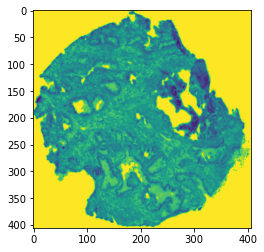

In [16]:
plot_sitk_image(fixed_img)

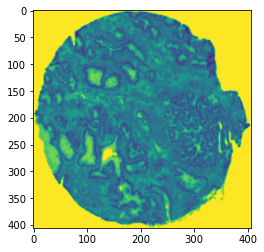

In [17]:
plot_sitk_image(moving_img)

In [18]:
normalize(fixed_img_path, moving_img_path)
fixed_img_path = 'fixed1.tif'
moving_img_path = 'moving1.tif'

In [19]:
fixed_img = sitk.ReadImage(fixed_img_path, sitk.sitkFloat32)
moving_img = sitk.ReadImage(moving_img_path, sitk.sitkFloat32)

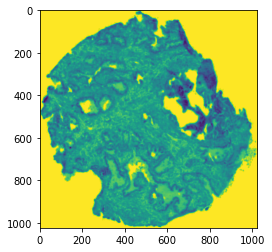

In [20]:
plot_sitk_image(fixed_img)

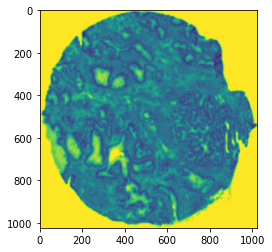

In [21]:
plot_sitk_image(moving_img)

### Segmentation

In [133]:
threshold_filters = {'Otsu': sitk.OtsuThresholdImageFilter(),
                     'Triangle' : sitk.TriangleThresholdImageFilter(),
                     'Huang' : sitk.HuangThresholdImageFilter(),
                     'MaxEntropy' : sitk.MaximumEntropyThresholdImageFilter()}

filter_selection = 'Otsu'
try:
    thresh_filter = threshold_filters[filter_selection]
    thresh_filter.SetInsideValue(1)
    thresh_filter.SetOutsideValue(0)
    segmented_img_fixed = thresh_filter.Execute(fixed_img)
    thresh_value_fixed = thresh_filter.GetThreshold()
except KeyError:
    thresh_value_fixed = 120
    segmented_img_fixed = new_image_sitk > thresh_value_fixed

print("Threshold used: " + str(thresh_value_fixed))    
# gui.MultiImageDisplay(image_list = [sitk.LabelOverlay(windows_sitk, thresh_img)],                   
#                       title_list = ['Binary Segmentation'], figure_size=(16,8));

# gui.multi_image_display2D(image_list = [sitk.LabelOverlay(fixed_img, thresh_img_fixed)],                   
#                       title_list = ['Binary Segmentation'], figure_size=(16, 8));

Threshold used: 203.5870819091797


In [134]:
threshold_filters = {'Otsu': sitk.OtsuThresholdImageFilter(),
                     'Triangle' : sitk.TriangleThresholdImageFilter(),
                     'Huang' : sitk.HuangThresholdImageFilter(),
                     'MaxEntropy' : sitk.MaximumEntropyThresholdImageFilter()}

filter_selection = 'Otsu'
try:
    thresh_filter = threshold_filters[filter_selection]
    thresh_filter.SetInsideValue(1)
    thresh_filter.SetOutsideValue(0)
    segmented_img_moving = thresh_filter.Execute(moving_img)
    thresh_value_moving = thresh_filter.GetThreshold()
except KeyError:
    thresh_value_moving = 120
    segmented_img_moving = new_image_sitk > thresh_value_moving

print("Threshold used: " + str(thresh_value_moving))    
# gui.MultiImageDisplay(image_list = [sitk.LabelOverlay(windows_sitk, thresh_img)],                   
#                       title_list = ['Binary Segmentation'], figure_size=(16,8));

# gui.multi_image_display2D(image_list = [sitk.LabelOverlay(fixed_img, thresh_img_fixed)],                   
#                       title_list = ['Binary Segmentation'], figure_size=(16, 8));

Threshold used: 183.43685913085938


In [135]:
fixed_img = sitk.ReadImage(fixed_img_path, sitk.sitkFloat32)
moving_img = sitk.ReadImage(moving_img_path, sitk.sitkFloat32)
# moving_img = sitk.ReadImage(fixed_img_path, sitk.sitkFloat32)

initial_transform = sitk.CenteredTransformInitializer(fixed_img, 
                                                      moving_img, 
                                                      sitk.Euler2DTransform(), 
                                                      sitk.CenteredTransformInitializerFilter.GEOMETRY)
print(initial_transform.GetParameters())

(0.0, 0.0, 0.0)


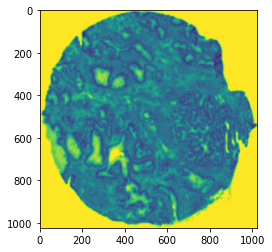

In [136]:
moving_resampled = sitk.Resample(moving_img, fixed_img, initial_transform, sitk.sitkLinear, 0.0, moving_img.GetPixelID())
plot_sitk_image(moving_resampled)

# Look how Lopes(?) did it in his paper

In [137]:
fixed_img = sitk.ReadImage(fixed_img_path, sitk.sitkFloat32)
moving_img = sitk.ReadImage(moving_img_path, sitk.sitkFloat32)

initial_transform = sitk.CenteredTransformInitializer(fixed_img, 
                                                      moving_img, 
                                                      sitk.AffineTransform(fixed_img.GetDimension()), 
                                                      sitk.CenteredTransformInitializerFilter.GEOMETRY)

# initial_transform = sitk.CenteredTransformInitializer(fixed_img, 
#                                                       moving_img, 
#                                                       sitk.Euler2DTransform(), 
#                                                       sitk.CenteredTransformInitializerFilter.GEOMETRY)


registration_method = sitk.ImageRegistrationMethod()
registration_method.SetOptimizerAsGradientDescent(learningRate=1.0, numberOfIterations=100, convergenceMinimumValue=1e-6, convergenceWindowSize=10)

In [154]:
fixed_img = sitk.ReadImage(fixed_img_path, sitk.sitkFloat32)
moving_img = sitk.ReadImage(moving_img_path, sitk.sitkFloat32)

initial_transform = sitk.CenteredTransformInitializer(fixed_img, 
                                                      moving_img, 
                                                      sitk.Euler2DTransform(), 
                                                      sitk.CenteredTransformInitializerFilter.GEOMETRY)
registration_method = sitk.ImageRegistrationMethod()

# Don't optimize in-place, we would possibly like to run this cell multiple times.
registration_method.SetInitialTransform(initial_transform, inPlace=False)

# Similarity metric settings.
# registration_method.SetMetricAsMattesMutualInformation(numberOfHistogramBins=7)
registration_method.SetMetricAsMeanSquares()
registration_method.SetMetricSamplingStrategy(registration_method.RANDOM)
registration_method.SetMetricSamplingPercentage(0.8)
registration_method.SetInterpolator(sitk.sitkLinear)
registration_method.SetMetricFixedMask(segmented_img_fixed)
registration_method.SetMetricMovingMask(segmented_img_moving)
# Optimizer settings.
# registration_method.SetOptimizerAsLBFGS2(numberOfIterations=1000)
registration_method.SetOptimizerAsExhaustive(numberOfSteps=[10,10,0])

# registration_method.SetOptimizerScalesFromPhysicalShift()

# Setup for the multi-resolution framework.
registration_method.SetShrinkFactorsPerLevel(shrinkFactors = [16,8,1])
registration_method.SetSmoothingSigmasPerLevel(smoothingSigmas=[2,1,0])

# registration_method.SetShrinkFactorsPerLevel(shrinkFactors = [16, 8, 4])
# registration_method.SetSmoothingSigmasPerLevel(smoothingSigmas=[2,1,0])


final_transform = registration_method.Execute(fixed_img, moving_img)

# Always check the reason optimization terminated.
print('Final metric value: {0}'.format(registration_method.GetMetricValue()))
print('Optimizer\'s stopping condition, {0}'.format(registration_method.GetOptimizerStopConditionDescription()))
print('Transform parameters: ', final_transform.GetParameters())

moving_resampled = sitk.Resample(moving_img, fixed_img, final_transform, sitk.sitkLinear, 1.0, moving_img.GetPixelID())

Final metric value: 1407.484585581617
Optimizer's stopping condition, ExhaustiveOptimizerv4: Completed sampling of parametric space of size 3
Transform parameters:  (-12.0, -10.0, 0.0)


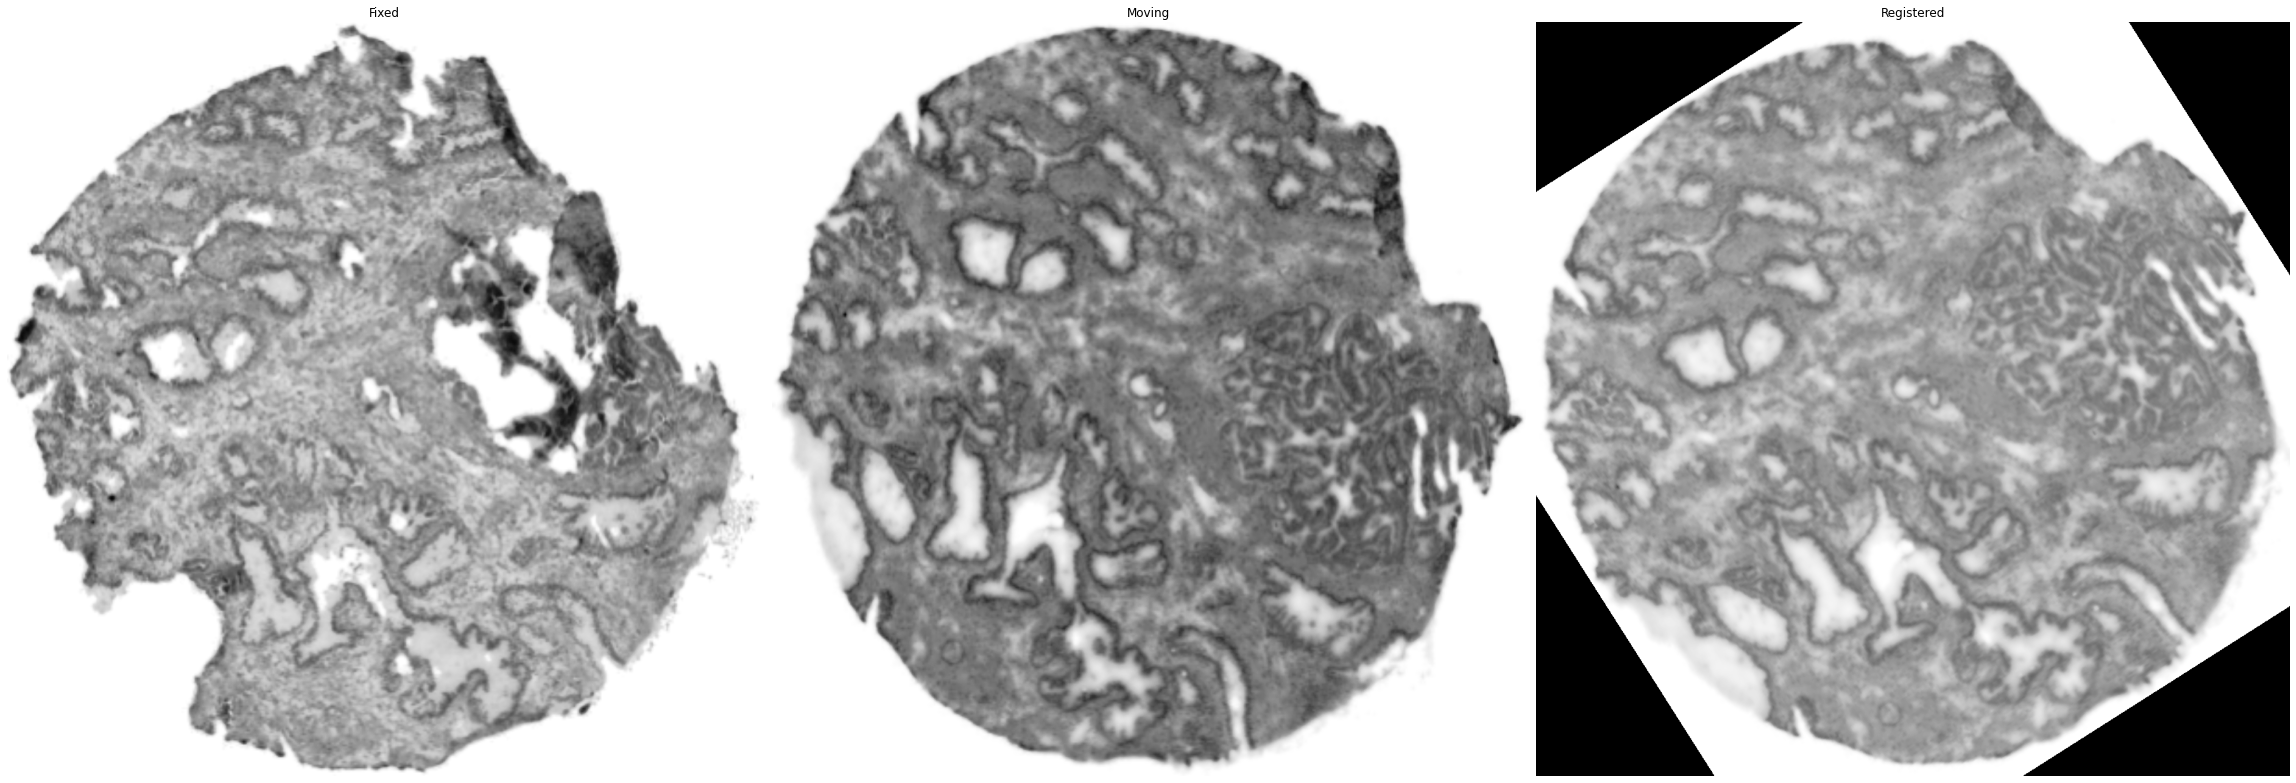

In [155]:
gui.multi_image_display2D(image_list = [fixed_img,
                                        moving_img,
                                        moving_resampled],                   
                      title_list = ['Fixed',
                                    'Moving',
                                    'Registered'
                                   ],
                      # shared_slider=True,
                      horizontal=True,
                      figure_size=(32,16));

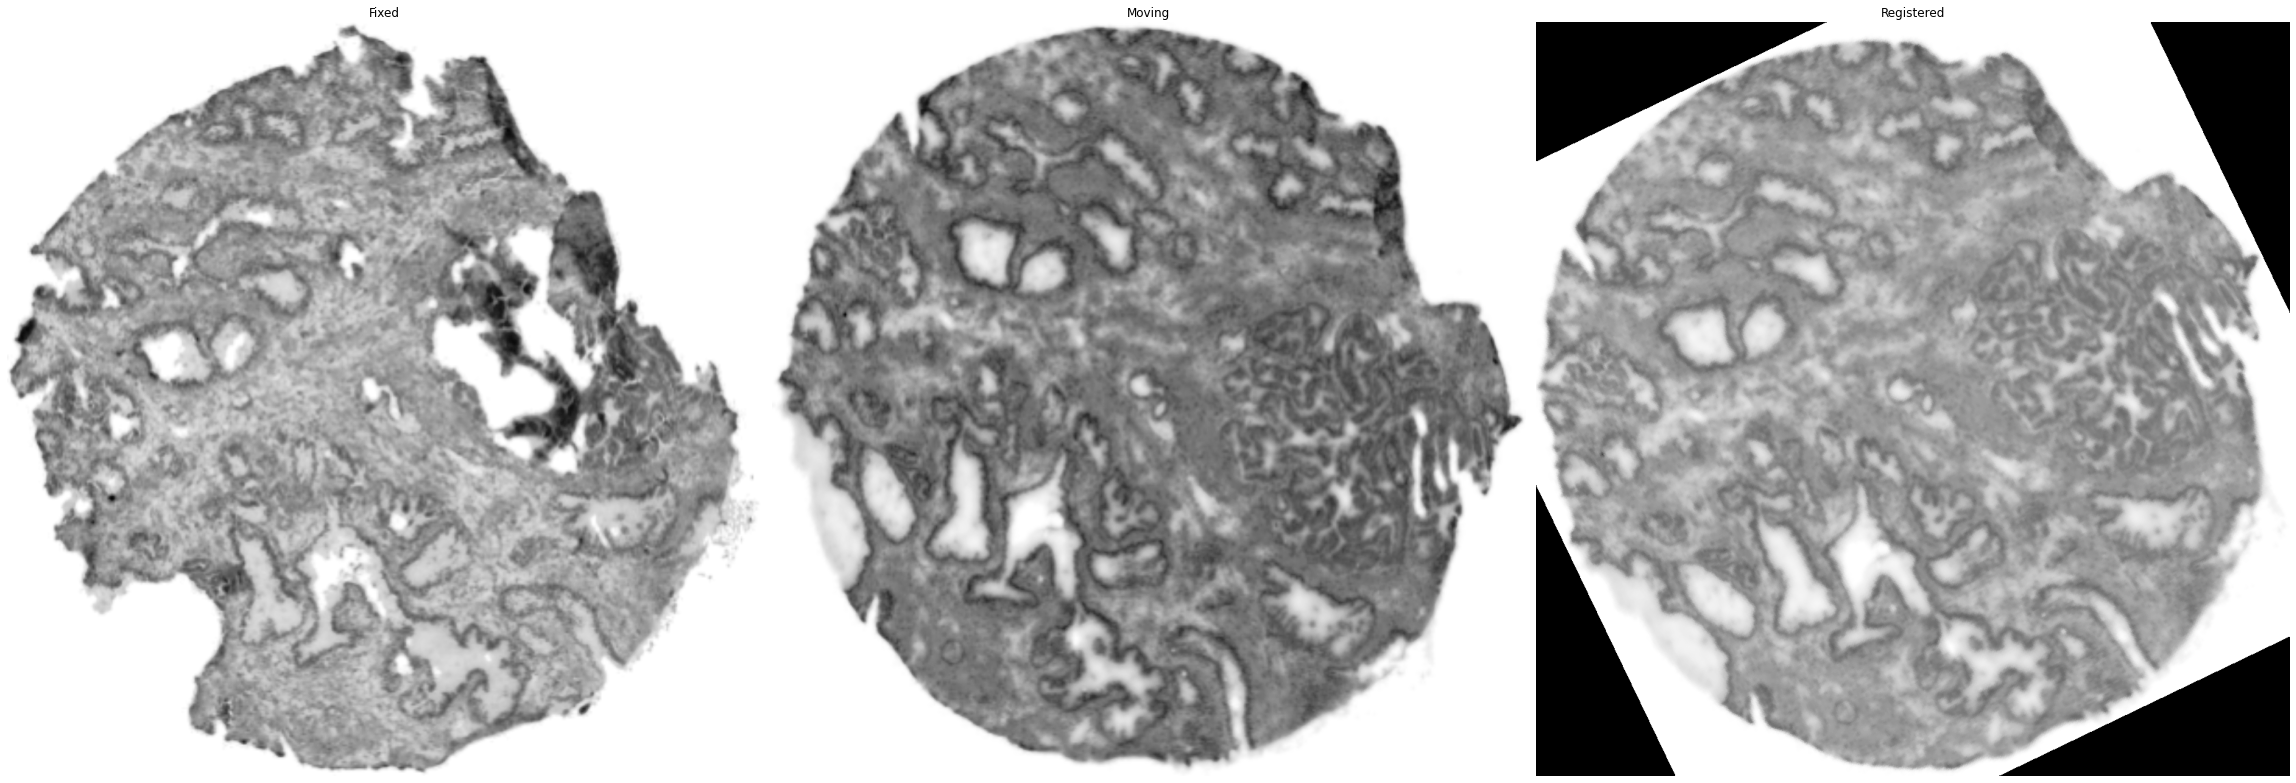

In [71]:
gui.multi_image_display2D(image_list = [fixed_img,
                                        moving_img,
                                        moving_resampled],                   
                      title_list = ['Fixed',
                                    'Moving',
                                    'Registered'
                                   ],
                      # shared_slider=True,
                      horizontal=True,
                      figure_size=(32,16));

In [63]:
?registration_method.SetOptimizerAsLBFGS2

Signature:
registration_method.SetOptimizerAsLBFGS2(
    solutionAccuracy=1e-05,
    numberOfIterations=0,
    hessianApproximateAccuracy=6,
    deltaConvergenceDistance=0,
    deltaConvergenceTolerance=1e-05,
    lineSearchMaximumEvaluations=40,
    lineSearchMinimumStep=1e-20,
    lineSearchMaximumStep=1e+20,
    lineSearchAccuracy=0.0001,
)
Docstring:
SetOptimizerAsLBFGS2(ImageRegistrationMethod self, double solutionAccuracy=1e-5, unsigned int numberOfIterations=0, unsigned int hessianApproximateAccuracy=6, unsigned int deltaConvergenceDistance=0, double deltaConvergenceTolerance=1e-5, unsigned int lineSearchMaximumEvaluations=40, double lineSearchMinimumStep=1e-20, double lineSearchMaximumStep=1e20, double lineSearchAccuracy=1e-4)


Limited memory Broyden Fletcher Goldfarb Shannon minimization without
bounds.


The default parameters utilize LBFGSB in unbounded mode. This version
is from LibLBFGS.

There are upto 3 stopping criteria:
the solution accuracy which is the magnitude of 

In [14]:
fixed_img = sitk.ReadImage(fixed_img_path, sitk.sitkUInt32)
moving_img = sitk.ReadImage(moving_img_path, sitk.sitkUInt32)

TIFFReadDirectory: Warning, Unknown field with tag 50838 (0xc696) encountered.
TIFFReadDirectory: Warning, Unknown field with tag 50839 (0xc697) encountered.
TIFFReadDirectory: Warning, Unknown field with tag 50838 (0xc696) encountered.
TIFFReadDirectory: Warning, Unknown field with tag 50839 (0xc697) encountered.


### Segmenation of stain from background
#### Fixed Image

In [16]:
threshold_filters = {'Otsu': sitk.OtsuThresholdImageFilter(),
                     'Triangle' : sitk.TriangleThresholdImageFilter(),
                     'Huang' : sitk.HuangThresholdImageFilter(),
                     'MaxEntropy' : sitk.MaximumEntropyThresholdImageFilter()}

filter_selection = 'Otsu'
try:
    thresh_filter = threshold_filters[filter_selection]
    thresh_filter.SetInsideValue(1)
    thresh_filter.SetOutsideValue(0)
    thresh_img_fixed = thresh_filter.Execute(fixed_img)
    thresh_value_fixed = thresh_filter.GetThreshold()
except KeyError:
    thresh_value_fixed = 120
    thresh_img_fixed = new_image_sitk > thresh_value_fixed

print("Threshold used: " + str(thresh_value_fixed))    
# gui.MultiImageDisplay(image_list = [sitk.LabelOverlay(windows_sitk, thresh_img)],                   
#                       title_list = ['Binary Segmentation'], figure_size=(16,8));

# gui.multi_image_display2D(image_list = [sitk.LabelOverlay(fixed_img, thresh_img_fixed)],                   
#                       title_list = ['Binary Segmentation'], figure_size=(32, 16));

Threshold used: 186.0


#### Moving Image

In [17]:
threshold_filters = {'Otsu': sitk.OtsuThresholdImageFilter(),
                     'Triangle' : sitk.TriangleThresholdImageFilter(),
                     'Huang' : sitk.HuangThresholdImageFilter(),
                     'MaxEntropy' : sitk.MaximumEntropyThresholdImageFilter()}

filter_selection = 'Otsu'
try:
    thresh_filter = threshold_filters[filter_selection]
    thresh_filter.SetInsideValue(1)
    thresh_filter.SetOutsideValue(0)
    thresh_img_moving = thresh_filter.Execute(moving_img)
    thresh_value_moving = thresh_filter.GetThreshold()
except KeyError:
    thresh_value_moving = 120
    thresh_img_moving = new_image_sitk > thresh_value_moving

print("Threshold used: " + str(thresh_value_moving))    
# gui.MultiImageDisplay(image_list = [sitk.LabelOverlay(windows_sitk, thresh_img)],                   
#                       title_list = ['Binary Segmentation'], figure_size=(16,8));

# gui.multi_image_display2D(image_list = [sitk.LabelOverlay(moving_img, thresh_img_moving)],                   
#                       title_list = ['Binary Segmentation'], figure_size=(32, 16));

Threshold used: 197.0


In [15]:
# fixed_img = sitk.ReadImage(fixed_img_path, sitk.sitkFloat32)
# moving_img = sitk.ReadImage(moving_img_path, sitk.sitkFloat32)

TIFFReadDirectory: Warning, Unknown field with tag 50838 (0xc696) encountered.
TIFFReadDirectory: Warning, Unknown field with tag 50839 (0xc697) encountered.
TIFFReadDirectory: Warning, Unknown field with tag 50838 (0xc696) encountered.
TIFFReadDirectory: Warning, Unknown field with tag 50839 (0xc697) encountered.


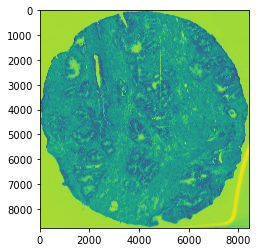

In [16]:
# plot_sitk_image(fixed_img)

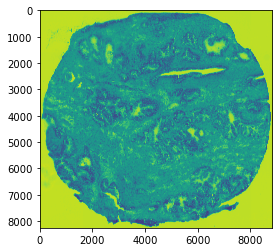

In [17]:
# plot_sitk_image(moving_img)

In [54]:
batches

[{'source_image_path': '/home/maximilw/workbench/wsi/exports/frozen_storage/normalized_frozen_storage/MS-F-1_FlexExport3_3_B.tif',
  'target_image_path': '/home/maximilw/workbench/wsi/exports/frozen_storage/normalized_frozen_storage/MS-V-1_FlexExport2_0_B.tif'},
 {'source_image_path': '/home/maximilw/workbench/wsi/exports/frozen_storage/normalized_frozen_storage/MS-V-1_FlexExport2_0_B.tif',
  'target_image_path': '/home/maximilw/workbench/wsi/exports/frozen_storage/normalized_frozen_storage/MS-FV-1_FlexExport2_0_B.tif'},
 {'source_image_path': '/home/maximilw/workbench/wsi/exports/frozen_storage/normalized_frozen_storage/MS-FV-1_FlexExport2_0_B.tif',
  'target_image_path': '/home/maximilw/workbench/wsi/exports/frozen_storage/normalized_frozen_storage/MS-F-2_FlexExport2_2_B.tif'},
 {'source_image_path': '/home/maximilw/workbench/wsi/exports/frozen_storage/normalized_frozen_storage/MS-F-2_FlexExport2_2_B.tif',
  'target_image_path': '/home/maximilw/workbench/wsi/exports/frozen_storage/no

[405.0, 405.0]


LBFGS2Optimizerv4 (0x55e2f96bd660): LBFGS optimizer does not support scaling. All scales are set to one.



-------
Image (0x55e2ff963e00)
  RTTI typeinfo:   itk::Image<float, 2u>
  Reference Count: 1
  Modified Time: 259749
  Debug: Off
  Object Name: 
  Observers: 
    none
  Source: (none)
  Source output name: (none)
  Release Data: Off
  Data Released: False
  Global Release Data: Off
  PipelineMTime: 259741
  UpdateMTime: 259748
  RealTimeStamp: 0 seconds 
  LargestPossibleRegion: 
    Dimension: 2
    Index: [0, 0]
    Size: [405, 405]
  BufferedRegion: 
    Dimension: 2
    Index: [0, 0]
    Size: [405, 405]
  RequestedRegion: 
    Dimension: 2
    Index: [0, 0]
    Size: [405, 405]
  Spacing: [1, 1]
  Origin: [0, 0]
  Direction: 
1 0
0 1

  IndexToPointMatrix: 
1 0
0 1

  PointToIndexMatrix: 
1 0
0 1

  Inverse Direction: 
1 0
0 1

  PixelContainer: 
    ImportImageContainer (0x55e302b34670)
      RTTI typeinfo:   itk::ImportImageContainer<unsigned long, float>
      Reference Count: 1
      Modified Time: 259746
      Debug: Off
      Object Name: 
      Observers: 
        none
  

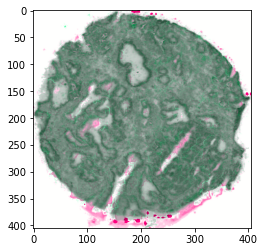

In [47]:
# fixed_image_mask = None
fixed_points = None
moving_points = None

registration_method = sitk.ImageRegistrationMethod()

# Determine the number of BSpline control points using the physical spacing we
# want for the finest resolution control grid.
#     grid_physical_spacing = [25.0, 25.0, 25.0]  # A control point every 50mm
grid_physical_spacing = [1.0, 1.0]  # A control point every 50mm
# grid_physical_spacing = [0.5, 0.5, 0.5]  # A control point every 50mm
image_physical_size = [
    size * spacing
    for size, spacing in zip(fixed.GetSize(), fixed.GetSpacing())
]
print(image_physical_size)
mesh_size = [
    int(image_size / grid_spacing + 0.5)
    for image_size, grid_spacing in zip(image_physical_size, grid_physical_spacing)
]

# The starting mesh size will be 1/4 of the original, it will be refined by
# the multi-resolution framework.
mesh_size = [int(sz / 4 + 0.5) for sz in mesh_size]

initial_transform = sitk.BSplineTransformInitializer(
    image1=fixed, transformDomainMeshSize=mesh_size, order=1
)

# Instead of the standard SetInitialTransform we use the BSpline specific method which also
# accepts the scaleFactors parameter to refine the BSpline mesh. In this case we start with
# the given mesh_size at the highest pyramid level then we double it in the next lower level and
# in the full resolution image we use a mesh that is four times the original size.
registration_method.SetInitialTransformAsBSpline(
    initial_transform, inPlace=True, scaleFactors=[2, 1]
)
registration_method.SetMetricAsMeanSquares()
# Settings for metric sampling, usage of a mask is optional. When given a mask the sample points will be
# generated inside that region. Also, this implicitly speeds things up as the mask is smaller than the
# whole image.
registration_method.SetMetricSamplingStrategy(registration_method.REGULAR)
# registration_method.SetMetricSamplingPercentage(0.2)
if fixed_image_mask:
    registration_method.SetMetricFixedMask(fixed_image_mask)

# Multi-resolution framework.
registration_method.SetShrinkFactorsPerLevel(shrinkFactors=[4, 1])
registration_method.SetSmoothingSigmasPerLevel(smoothingSigmas=[1, 0])
#     registration_method.SmoothingSigmasAreSpecifiedInPhysicalUnitsOn()

registration_method.SetInterpolator(sitk.sitkLinear)
# Use the LBFGS2 instead of LBFGS. The latter cannot adapt to the changing control grid resolution.
registration_method.SetOptimizerAsLBFGS2(
    solutionAccuracy=1e-2, numberOfIterations=500, deltaConvergenceTolerance=0.001
)
# registration_method.SetOptimizerAsExhaustive(numberOfSteps=[1000])


# If corresponding points in the fixed and moving image are given then we display the similarity metric
# and the TRE during the registration.
if fixed_points and moving_points:
    registration_method.AddCommand(
        sitk.sitkStartEvent, rc.metric_and_reference_start_plot
    )
    registration_method.AddCommand(
        sitk.sitkEndEvent, rc.metric_and_reference_end_plot
    )
    registration_method.AddCommand(
        sitk.sitkIterationEvent,
        lambda: rc.metric_and_reference_plot_values(
            registration_method, fixed_points, moving_points
        ),
    )

    
# registration_method.AddCommand(sitk.sitkIterationEvent, lambda: command_iteration(registration_method))
# tx = registration_method.Execute(fixed, moving)
tx = registration_method.Execute(fixed, moving)

resampler = sitk.ResampleImageFilter()
resampler.SetReferenceImage(fixed)
resampler.SetInterpolator(sitk.sitkLinear)
resampler.SetDefaultPixelValue(1)
resampler.SetTransform(tx)

out = resampler.Execute(moving)

print("-------")
print(out)
print(f"Optimizer stop condition: {registration_method.GetOptimizerStopConditionDescription()}")
print(f" Iteration: {registration_method.GetOptimizerIteration()}")
print(f" Metric value: {registration_method.GetMetricValue()}")

simg1 = sitk.Cast(sitk.RescaleIntensity(fixed), sitk.sitkUInt8)
simg2 = sitk.Cast(sitk.RescaleIntensity(out), sitk.sitkUInt8)
cimg = sitk.Compose(simg1, simg2, simg1 // 2. + simg2 // 2.)

plot_sitk_image(cimg);

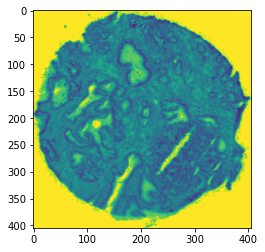

In [49]:
plot_sitk_image(simg1)

In [50]:
simg2

<SimpleITK.SimpleITK.Image; proxy of <Swig Object of type 'std::vector< itk::simple::Image >::value_type *' at 0x7fbec716bf90> >

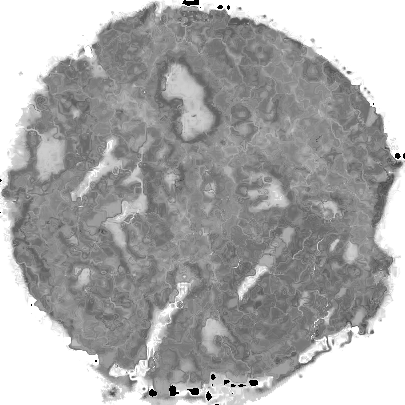

In [54]:
sitk_to_pil(out)

In [222]:
fixed_mat = sitk.GetArrayFromImage(fixed)/65025
out_mat = sitk.GetArrayFromImage(out)/65025
out_mat

array([[1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       ...,
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.]], dtype=float32)

In [223]:
fixed_mat = sitk.GetArrayFromImage(fixed)/65025
out_mat = sitk.GetArrayFromImage(out)/65025
out_mat
score = []
for i in range(fixed_mat.shape[0]):
    for j in range(fixed_mat.shape[1]):
        if fixed_image_mask[i,j] == 1:
            score.append(np.abs(fixed_mat[i,j] - out_mat[i,j]))
score = np.array(score)

In [55]:
np.array(score)

array([0.15275681, 0.02209151, 0.        , ..., 0.2005741 , 0.20366234,
       0.18851882], dtype=float32)

In [56]:
registration_method.GetMetricValue() / (65025)

196.1794433685309

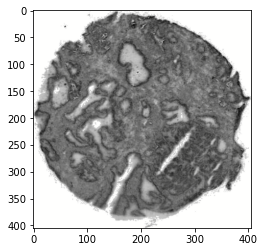

In [57]:
plot_sitk_image(sitk.Compose(simg1, simg1, simg1 // 2. + simg1 // 2.))

# TODO
1. Write storing mechanisms. (Create folder for each transformation. Store fixed, out, between images gray,pink and green, and statistics.)
2. Implement order for images.
3. Create one example for chaining more than a pair (img1 -> img2 -> img3).

In [ ]:
# fixed_image_mask = None
fixed_points = None
moving_points = None

registration_method = sitk.ImageRegistrationMethod()

# Determine the number of BSpline control points using the physical spacing we
# want for the finest resolution control grid.
#     grid_physical_spacing = [25.0, 25.0, 25.0]  # A control point every 50mm
grid_physical_spacing = [1.0, 1.0, 1.0]  # A control point every 50mm
image_physical_size = [
    size * spacing
    for size, spacing in zip(fixed.GetSize(), fixed.GetSpacing())
]
print(image_physical_size)
mesh_size = [
    int(image_size / grid_spacing + 0.5)
    for image_size, grid_spacing in zip(image_physical_size, grid_physical_spacing)
]

# The starting mesh size will be 1/4 of the original, it will be refined by
# the multi-resolution framework.
mesh_size = [int(sz / 4 + 0.5) for sz in mesh_size]

initial_transform = sitk.BSplineTransformInitializer(
    image1=fixed, transformDomainMeshSize=mesh_size, order=1
)

# Instead of the standard SetInitialTransform we use the BSpline specific method which also
# accepts the scaleFactors parameter to refine the BSpline mesh. In this case we start with
# the given mesh_size at the highest pyramid level then we double it in the next lower level and
# in the full resolution image we use a mesh that is four times the original size.
registration_method.SetInitialTransformAsBSpline(
    initial_transform, inPlace=True, scaleFactors=[2, 2, 2, 1, 1]
)
registration_method.SetMetricAsMeanSquares()
# Settings for metric sampling, usage of a mask is optional. When given a mask the sample points will be
# generated inside that region. Also, this implicitly speeds things up as the mask is smaller than the
# whole image.
registration_method.SetMetricSamplingStrategy(registration_method.RANDOM)
registration_method.SetMetricSamplingPercentage(0.2)
if fixed_image_mask:
    registration_method.SetMetricFixedMask(fixed_image_mask)

# Multi-resolution framework.
registration_method.SetShrinkFactorsPerLevel(shrinkFactors=[8, 8, 4, 2, 1])
registration_method.SetSmoothingSigmasPerLevel(smoothingSigmas=[8, 4, 2, 1, 0])
#     registration_method.SmoothingSigmasAreSpecifiedInPhysicalUnitsOn()

registration_method.SetInterpolator(sitk.sitkLinear)
# Use the LBFGS2 instead of LBFGS. The latter cannot adapt to the changing control grid resolution.
registration_method.SetOptimizerAsLBFGS2(
    solutionAccuracy=1e-2, numberOfIterations=1000, deltaConvergenceTolerance=0.001
)
# registration_method.SetOptimizerAsExhaustive(numberOfSteps=[1000])


# If corresponding points in the fixed and moving image are given then we display the similarity metric
# and the TRE during the registration.
if fixed_points and moving_points:
    registration_method.AddCommand(
        sitk.sitkStartEvent, rc.metric_and_reference_start_plot
    )
    registration_method.AddCommand(
        sitk.sitkEndEvent, rc.metric_and_reference_end_plot
    )
    registration_method.AddCommand(
        sitk.sitkIterationEvent,
        lambda: rc.metric_and_reference_plot_values(
            registration_method, fixed_points, moving_points
        ),
    )

tx = registration_method.Execute(fixed, moving)

resampler = sitk.ResampleImageFilter()
resampler.SetReferenceImage(fixed)
resampler.SetInterpolator(sitk.sitkLinear)
resampler.SetDefaultPixelValue(1)
resampler.SetTransform(tx)

out = resampler.Execute(moving)

simg1 = sitk.Cast(sitk.RescaleIntensity(fixed), sitk.sitkUInt8)
simg2 = sitk.Cast(sitk.RescaleIntensity(out), sitk.sitkUInt8)
cimg = sitk.Compose(simg1, simg2, simg1 // 2. + simg2 // 2.)

plot_sitk_image(cimg);
print("BLUR OUT OR GET SOMEHOW ELSE RID OF DETAILS OF IMAGE!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!")

In [ ]:
def save_img(path, image):
    fig, ax = plt.subplots( nrows=1, ncols=1 )
    ax.imshow(sitk.GetArrayFromImage(image))
    ax.savefig(path)
    plt.close()
    
simg1 = sitk.Cast(sitk.RescaleIntensity(fixed), sitk.sitkUInt8)
simg2 = sitk.Cast(sitk.RescaleIntensity(out), sitk.sitkUInt8)
cimg = sitk.Compose(simg1, simg2, simg1 // 2. + simg2 // 2.)
plot_sitk_image(cimg);
    

In [ ]:
fig, ax = plt.subplots( nrows=1, ncols=1 )
ax.imshow(sitk.GetArrayFromImage(cimg))
fig.savefig('here.tif')
plt.close()

In [ ]:
fixed_save = fixed
out_save = out
simg1 = sitk.Cast(sitk.RescaleIntensity(fixed_save), sitk.sitkUInt8)
simg2 = sitk.Cast(sitk.RescaleIntensity(out_save), sitk.sitkUInt8)
cimg_save = sitk.Compose(simg1, simg2, simg1 // 2. + simg2 // 2.)
plot_sitk_image(cimg_save);

In [ ]:
a = openslide.open_slide('here.tif')
b = a.read_region((0,0), 0 , a.dimensions)
b


In [ ]:
plot_sitk_image(simg1);

In [ ]:
plot_sitk_image(simg2);

In [ ]:
plot_sitk_image(moving);

# https://simpleitk.readthedocs.io/en/master/filters.html
#https://simpleitk.readthedocs.io/en/master/IO.html
#https://simpleitk.readthedocs.io/en/master/registrationOverview.html
https://github.com/gregpost/ITK-SimpleITK-Converter/blob/main/itk_sitk_converter.py

In [38]:
# simg1 = sitk.Cast(sitk.RescaleIntensity(fixed), sitk.sitkUInt8)
# simg2 = sitk.Cast(sitk.RescaleIntensity(moving), sitk.sitkUInt8)
# cimg = sitk.Compose(simg1, simg2, simg1 // 2. + simg2 // 2.)
# plot_sitk_image(cimg)

In [30]:
def bspline_intra_modal_registration(
    fixed_image,
    moving_image,
    fixed_image_mask=None,
    fixed_points=None,
    moving_points=None,
):

    registration_method = sitk.ImageRegistrationMethod()

    # Determine the number of BSpline control points using the physical spacing we want for the control grid.
    grid_physical_spacing = [50.0, 50.0, 50.0]  # A control point every 50mm
    image_physical_size = [
        size * spacing
        for size, spacing in zip(fixed_image.GetSize(), fixed_image.GetSpacing())
    ]
    mesh_size = [
        int(image_size / grid_spacing + 0.5)
        for image_size, grid_spacing in zip(image_physical_size, grid_physical_spacing)
    ]

    initial_transform = sitk.BSplineTransformInitializer(
        image1=fixed_image, transformDomainMeshSize=mesh_size, order=3
    )
    registration_method.SetInitialTransform(initial_transform)

    registration_method.SetMetricAsMeanSquares()
    # Settings for metric sampling, usage of a mask is optional. When given a mask the sample points will be
    # generated inside that region. Also, this implicitly speeds things up as the mask is smaller than the
    # whole image.
    registration_method.SetMetricSamplingStrategy(registration_method.RANDOM)
    registration_method.SetMetricSamplingPercentage(0.01)
    if fixed_image_mask:
        registration_method.SetMetricFixedMask(fixed_image_mask)

    # Multi-resolution framework.
    registration_method.SetShrinkFactorsPerLevel(shrinkFactors=[4, 2, 1])
    registration_method.SetSmoothingSigmasPerLevel(smoothingSigmas=[2, 1, 0])
    registration_method.SmoothingSigmasAreSpecifiedInPhysicalUnitsOn()

    registration_method.SetInterpolator(sitk.sitkLinear)
    registration_method.SetOptimizerAsLBFGSB(
        gradientConvergenceTolerance=1e-5, numberOfIterations=100
    )

    # If corresponding points in the fixed and moving image are given then we display the similarity metric
    # and the TRE during the registration.
    if fixed_points and moving_points:
        registration_method.AddCommand(
            sitk.sitkStartEvent, rc.metric_and_reference_start_plot
        )
        registration_method.AddCommand(
            sitk.sitkEndEvent, rc.metric_and_reference_end_plot
        )
        registration_method.AddCommand(
            sitk.sitkIterationEvent,
            lambda: rc.metric_and_reference_plot_values(
                registration_method, fixed_points, moving_points
            ),
        )

    return registration_method.Execute(fixed_image, moving_image)

In [42]:
%%timeit -r1 -n1

# Select the fixed and moving images, valid entries are in [0,9].
fixed_image_index = 0
moving_image_index = 7


tx = bspline_intra_modal_registration(
    fixed_image=fixed,
    moving_image=moving,
#     fixed_image_mask=(masks[fixed_image_index] == lung_label),
#     fixed_points=points[fixed_image_index],
#     moving_points=points[moving_image_index],
)
# (
#     initial_errors_mean,
#     initial_errors_std,
#     _,
#     initial_errors_max,
#     initial_errors,
# ) = ru.registration_errors(
#     sitk.Euler3DTransform(), points[fixed_image_index], points[moving_image_index]
# )
# (
#     final_errors_mean,
#     final_errors_std,
#     _,
#     final_errors_max,
#     final_errors,
# ) = ru.registration_errors(tx, points[fixed_image_index], points[moving_image_index])

# plt.hist(initial_errors, bins=20, alpha=0.5, label="before registration", color="blue")
# plt.hist(final_errors, bins=20, alpha=0.5, label="after registration", color="green")
# plt.legend()
# plt.title("TRE histogram")
# print(
#     f"Initial alignment errors in millimeters, mean(std): {initial_errors_mean:.2f}({initial_errors_std:.2f}), max: {initial_errors_max:.2f}"
# )
# print(
#     f"Final alignment errors in millimeters, mean(std): {final_errors_mean:.2f}({final_errors_std:.2f}), max: {final_errors_max:.2f}"
# )

LBFGSBOptimizerv4 (0x55cb78059d90): LBFGSB optimizer does not support scaling. All scales are set to one.



1.42 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [ ]:
def bspline_intra_modal_registration2(
    fixed_image,
    moving_image,
    fixed_image_mask=None,
    fixed_points=None,
    moving_points=None,
):

    registration_method = sitk.ImageRegistrationMethod()

    # Determine the number of BSpline control points using the physical spacing we
    # want for the finest resolution control grid.
#     grid_physical_spacing = [25.0, 25.0, 25.0]  # A control point every 50mm
    grid_physical_spacing = [25.0, 25.0, 25.0]  # A control point every 50mm
    image_physical_size = [
        size * spacing
        for size, spacing in zip(fixed_image.GetSize(), fixed_image.GetSpacing())
    ]
    mesh_size = [
        int(image_size / grid_spacing + 0.5)
        for image_size, grid_spacing in zip(image_physical_size, grid_physical_spacing)
    ]

    # The starting mesh size will be 1/4 of the original, it will be refined by
    # the multi-resolution framework.
    mesh_size = [int(sz / 4 + 0.5) for sz in mesh_size]

    initial_transform = sitk.BSplineTransformInitializer(
        image1=fixed_image, transformDomainMeshSize=mesh_size, order=2
    )
    # Instead of the standard SetInitialTransform we use the BSpline specific method which also
    # accepts the scaleFactors parameter to refine the BSpline mesh. In this case we start with
    # the given mesh_size at the highest pyramid level then we double it in the next lower level and
    # in the full resolution image we use a mesh that is four times the original size.
    registration_method.SetInitialTransformAsBSpline(
        initial_transform, inPlace=True, scaleFactors=[1, 2, 4]
    )
    registration_method.SetMetricAsMeanSquares()
    # Settings for metric sampling, usage of a mask is optional. When given a mask the sample points will be
    # generated inside that region. Also, this implicitly speeds things up as the mask is smaller than the
    # whole image.
    registration_method.SetMetricSamplingStrategy(registration_method.RANDOM)
    registration_method.SetMetricSamplingPercentage(0.01)
    if fixed_image_mask:
        registration_method.SetMetricFixedMask(fixed_image_mask)

    # Multi-resolution framework.
    registration_method.SetShrinkFactorsPerLevel(shrinkFactors=[4, 2, 1])
    registration_method.SetSmoothingSigmasPerLevel(smoothingSigmas=[2, 1, 0])
    registration_method.SmoothingSigmasAreSpecifiedInPhysicalUnitsOn()

    registration_method.SetInterpolator(sitk.sitkLinear)
    # Use the LBFGS2 instead of LBFGS. The latter cannot adapt to the changing control grid resolution.
    registration_method.SetOptimizerAsLBFGS2(
        solutionAccuracy=1e-2, numberOfIterations=1000, deltaConvergenceTolerance=0.01
    )

    # If corresponding points in the fixed and moving image are given then we display the similarity metric
    # and the TRE during the registration.
    if fixed_points and moving_points:
        registration_method.AddCommand(
            sitk.sitkStartEvent, rc.metric_and_reference_start_plot
        )
        registration_method.AddCommand(
            sitk.sitkEndEvent, rc.metric_and_reference_end_plot
        )
        registration_method.AddCommand(
            sitk.sitkIterationEvent,
            lambda: rc.metric_and_reference_plot_values(
                registration_method, fixed_points, moving_points
            ),
        )

    return registration_method.Execute(fixed_image, moving_image)

In [91]:
def bspline_intra_modal_registration2(
    fixed_image,
    moving_image,
    fixed_image_mask=None,
    fixed_points=None,
    moving_points=None,
):

    registration_method = sitk.ImageRegistrationMethod()

    # Determine the number of BSpline control points using the physical spacing we
    # want for the finest resolution control grid.
#     grid_physical_spacing = [25.0, 25.0, 25.0]  # A control point every 50mm
    grid_physical_spacing = [25.0, 25.0, 25.0]  # A control point every 50mm
    image_physical_size = [
        size * spacing
        for size, spacing in zip(fixed_image.GetSize(), fixed_image.GetSpacing())
    ]
    mesh_size = [
        int(image_size / grid_spacing + 0.5)
        for image_size, grid_spacing in zip(image_physical_size, grid_physical_spacing)
    ]

    # The starting mesh size will be 1/4 of the original, it will be refined by
    # the multi-resolution framework.
    mesh_size = [int(sz / 4 + 0.5) for sz in mesh_size]

    initial_transform = sitk.BSplineTransformInitializer(
        image1=fixed_image, transformDomainMeshSize=mesh_size, order=2
    )
    # Instead of the standard SetInitialTransform we use the BSpline specific method which also
    # accepts the scaleFactors parameter to refine the BSpline mesh. In this case we start with
    # the given mesh_size at the highest pyramid level then we double it in the next lower level and
    # in the full resolution image we use a mesh that is four times the original size.
    registration_method.SetInitialTransformAsBSpline(
        initial_transform, inPlace=True, scaleFactors=[1]
    )
    registration_method.SetMetricAsMeanSquares()
    # Settings for metric sampling, usage of a mask is optional. When given a mask the sample points will be
    # generated inside that region. Also, this implicitly speeds things up as the mask is smaller than the
    # whole image.
    registration_method.SetMetricSamplingStrategy(registration_method.RANDOM)
    registration_method.SetMetricSamplingPercentage(0.01)
    if fixed_image_mask:
        registration_method.SetMetricFixedMask(fixed_image_mask)

    # Multi-resolution framework.
    registration_method.SetShrinkFactorsPerLevel(shrinkFactors=[2, 1])
    registration_method.SetSmoothingSigmasPerLevel(smoothingSigmas=[1, 0])
#     registration_method.SmoothingSigmasAreSpecifiedInPhysicalUnitsOn()

    registration_method.SetInterpolator(sitk.sitkLinear)
    # Use the LBFGS2 instead of LBFGS. The latter cannot adapt to the changing control grid resolution.
    registration_method.SetOptimizerAsLBFGS2(
        solutionAccuracy=1e-2, numberOfIterations=1000, deltaConvergenceTolerance=0.01
    )

    # If corresponding points in the fixed and moving image are given then we display the similarity metric
    # and the TRE during the registration.
    if fixed_points and moving_points:
        registration_method.AddCommand(
            sitk.sitkStartEvent, rc.metric_and_reference_start_plot
        )
        registration_method.AddCommand(
            sitk.sitkEndEvent, rc.metric_and_reference_end_plot
        )
        registration_method.AddCommand(
            sitk.sitkIterationEvent,
            lambda: rc.metric_and_reference_plot_values(
                registration_method, fixed_points, moving_points
            ),
        )

    return registration_method.Execute(fixed_image, moving_image)

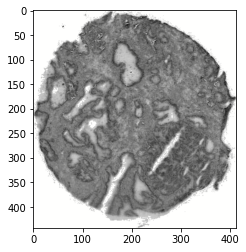

In [19]:
simg1 = sitk.Cast(sitk.RescaleIntensity(fixed), sitk.sitkUInt8)
simg2 = sitk.Cast(sitk.RescaleIntensity(fixed), sitk.sitkUInt8)
cimg = sitk.Compose(simg1, simg2, simg1 // 2. + simg2 // 2.)
plot_sitk_image(cimg)

LBFGS2Optimizerv4 (0x55cb7cdd5430): LBFGS optimizer does not support scaling. All scales are set to one.



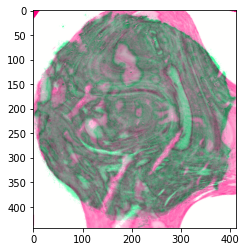

In [92]:
tx = bspline_intra_modal_registration2(
    fixed_image=fixed,
    moving_image=moving)


resampler = sitk.ResampleImageFilter()
resampler.SetReferenceImage(fixed)
resampler.SetInterpolator(sitk.sitkLinear)
resampler.SetDefaultPixelValue(1)
resampler.SetTransform(tx)

out = resampler.Execute(moving)

simg1 = sitk.Cast(sitk.RescaleIntensity(fixed), sitk.sitkUInt8)
simg2 = sitk.Cast(sitk.RescaleIntensity(out), sitk.sitkUInt8)
cimg = sitk.Compose(simg1, simg2, simg1 // 2. + simg2 // 2.)
plot_sitk_image(cimg)

In [ ]:
R = sitk.ImageRegistrationMethod()

# Metric does not seem to be too much of an influence as we will be able to get a perfect matching, since moving
# image is only a rotation of the fixed image.
R.SetMetricAsJointHistogramMutualInformation(50)
# R.SetMetricAsMeanSquares()

# For exhaustive optimization apparently only the first dimension needs to be set for number of steps. Interface
# to be used for both 2D and 3D.
R.SetOptimizerAsExhaustive([25, 0, 0])
R.SetOptimizerScalesFromIndexShift()

tx = sitk.CenteredTransformInitializer(fixed, moving,
                                       sitk.Euler2DTransform())
R.SetInitialTransform(tx)

R.SetInterpolator(sitk.sitkLinear)

R.AddCommand(sitk.sitkIterationEvent, lambda: command_iteration(R))

outTx = R.Execute(fixed, moving)

print("-------")
print(outTx)
print(f"Optimizer stop condition: {R.GetOptimizerStopConditionDescription()}")
print(f" Iteration: {R.GetOptimizerIteration()}")
print(f" Metric value: {R.GetMetricValue()}")

# sitk.WriteTransform(outTx, sys.argv[3])

resampler = sitk.ResampleImageFilter()
resampler.SetReferenceImage(fixed)
resampler.SetInterpolator(sitk.sitkLinear)
resampler.SetDefaultPixelValue(1)
resampler.SetTransform(outTx)

out = resampler.Execute(moving)

simg1 = sitk.Cast(sitk.RescaleIntensity(fixed), sitk.sitkUInt8)
simg2 = sitk.Cast(sitk.RescaleIntensity(out), sitk.sitkUInt8)
cimg = sitk.Compose(simg1, simg2, simg1 // 2. + simg2 // 2.)
plot_sitk_image(cimg)